In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input/fake.csv
input/true.csv


# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation, Flatten
from keras.models import Sequential

import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Dataset

In [4]:
true_df = pd.read_csv('./input/true.csv', error_bad_lines=False, engine='python')
false_df = pd.read_csv('./input/fake.csv', error_bad_lines=False, engine='python')

print(true_df.shape, false_df.shape)

true_df.drop(true_df.index[1001:], inplace=True)
false_df.drop(false_df.index[1001:], inplace=True)

<ipython-input-4-c41ad9f98ce7>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  true_df = pd.read_csv('./input/true.csv', error_bad_lines=False, engine='python')
<ipython-input-4-c41ad9f98ce7>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  false_df = pd.read_csv('./input/fake.csv', error_bad_lines=False, engine='python')


(21417, 4) (23481, 4)


# EDA

In [5]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
false_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
true_df['category'] = 1
false_df['category'] = 0

In [10]:
true_df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [11]:
text_df = pd.concat([true_df, false_df])

In [12]:
text_df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [13]:
text_df.title.count()

2002

In [14]:
text_df.subject.value_counts()

politicsNews    1001
News            1001
Name: subject, dtype: int64

In [15]:
text_df['text'] = text_df['text'] + " " + text_df['title'] + " " + text_df['subject']
del text_df['title']
del text_df['subject']
del text_df['date']

In [16]:
text_df.head()

,text,category
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


# Filter / stem / lem

In [17]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [18]:
stop

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [19]:
x_train, x_test, y_train, y_test = train_test_split(text_df.text, text_df.category)

print(len(x_train), len(x_test), len(y_train), len(y_test))

1501 501 1501 501


# Text2Vec

In [20]:
cv = CountVectorizer(min_df=0 ,max_df=1, ngram_range=(1,2))
cv_train = cv.fit_transform(x_train)
cv_test = cv.transform(x_test)

print('BOW_cv_train:', cv_train.shape)
print('BOW_cv_test:', cv_test.shape)

BOW_cv_train: (1501, 194907)
BOW_cv_test: (501, 194907)


# CNN

In [21]:
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = cv_train.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))

from tensorflow.keras.optimizers.legacy import Adam
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.fit(cv_train.toarray(), y_train, epochs=3)

pred = model.predict(cv_test)

for i in range(len(pred)):
    if(pred[i] > 0.5):
        pred[i] = 1
    else:
        pred[i] = 0

accuracy_score(pred, y_test)
cv_report = classification_report(y_test,pred,target_names = ['0','1'])
print(cv_report)

Epoch 1/3
47/47 [==============================] - 37s 696ms/step - loss: 0.6907 - accuracy: 0.5523
Epoch 2/3
47/47 [==============================] - 29s 616ms/step - loss: 0.1896 - accuracy: 0.9714
Epoch 3/3
16/16 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.70      0.82       250
           1       0.77      1.00      0.87       251

    accuracy                           0.85       501
   macro avg       0.88      0.85      0.85       501
weighted avg       0.88      0.85      0.85       501



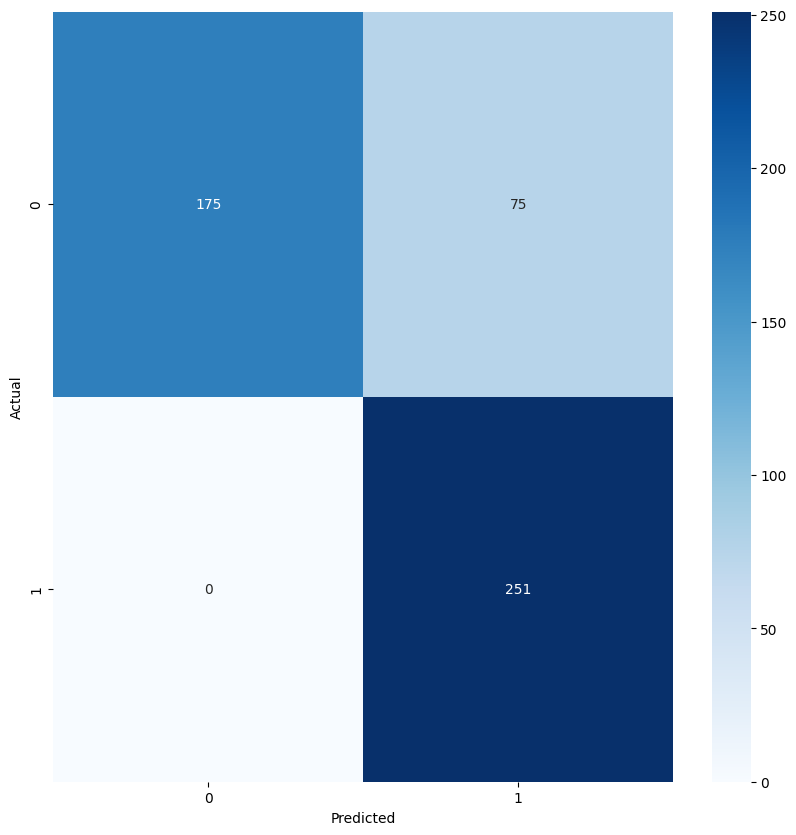

In [22]:
cm_cv = confusion_matrix(y_test, pred)
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap='Blues',annot = True, fmt='')

del model
del pred

# LSTM

Что бы не делал в ко-лабе памяти не хватает, на своей машине норм

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(1000,128))
# model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
# model.add(keras.layers.Bidirectional(keras.layers.LSTM(128)))
# model.add(keras.layers.Dense(128, activation='relu'))
# model.add(keras.layers.Dropout(0.6))
# model.add(keras.layers.Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.add(Bidirectional(LSTM(64)))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.fit(cv_train.toarray(), y_train, epochs=3)

pred = model.predict(cv_test)

for i in range(len(pred)):
    if(pred[i] > 0.5):
        pred[i] = 1
    else:
        pred[i] = 0

accuracy_score(pred,y_test)
cv_report = classification_report(y_test,pred,target_names = ['0','1'])
print(cv_report)

Epoch 1/3


In [ ]:
cm_cv = confusion_matrix(y_test, pred)
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap='Blues', annot=True, fmt='')